In [44]:
import math
import pandas as pd
from aws_helpers import execute_athena_query
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn; seaborn.set()
from matplotlib.dates import DayLocator, DateFormatter

end = datetime.today()
start = end - timedelta(days = 30)

sql = f"""
select * from weather
where observation_ts >= date('{start.strftime('%Y-%m-%d')}')
 and observation_ts < date('{end.strftime('%Y-%m-%d')}')
"""

results_url = execute_athena_query(sql)
df = pd.read_csv(results_url)

df['observation_ts'] = pd.to_datetime(df['observation_ts'])

df.head()

Executing: 
select * from weather
where observation_ts >= date('2021-12-05')
 and observation_ts < date('2022-01-04')

Wait count 0/30
Wait count 1/30
Query succeeded


,observation_ts,site_id,site_name,site_country,site_continent,site_elevation,lat,lon,wind_direction,screen_relative_humidity,pressure,wind_speed,temperature,visibility,weather_type,pressure_tendency,dew_point,year,month,day
0,2021-12-24 23:00:00,3002,BALTASOUND,SCOTLAND,EUROPE,15.0,60.749,-0.854,NNE,86.3,1014.0,5.0,0.4,28000.0,2.0,R,-1.4,2021,12,25
1,2021-12-25 00:00:00,3002,BALTASOUND,SCOTLAND,EUROPE,15.0,60.749,-0.854,W,82.4,1013.0,2.0,-0.7,28000.0,2.0,R,-2.9,2021,12,25
2,2021-12-25 01:00:00,3002,BALTASOUND,SCOTLAND,EUROPE,15.0,60.749,-0.854,WNW,73.1,1014.0,3.0,-1.6,35000.0,0.0,F,-5.1,2021,12,25
3,2021-12-25 02:00:00,3002,BALTASOUND,SCOTLAND,EUROPE,15.0,60.749,-0.854,WSW,81.5,1014.0,3.0,-0.4,40000.0,7.0,F,-2.8,2021,12,25
4,2021-12-25 03:00:00,3002,BALTASOUND,SCOTLAND,EUROPE,15.0,60.749,-0.854,WNW,86.7,1014.0,7.0,-0.1,40000.0,7.0,R,-1.8,2021,12,25


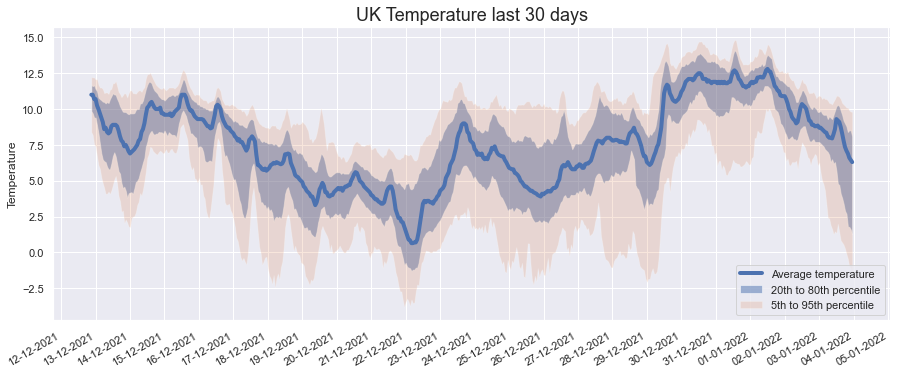

In [45]:
f, ax = plt.subplots(figsize=(15, 6))
ax.set_title('UK Temperature last 30 days', fontdict={'fontsize': '18', 'fontweight' : '3'})

temps = df[['observation_ts', 'temperature']]

outer_min = 0.05
outer_max = 0.95
mean = 0.5
inner_min = 0.2
inner_max = 0.8

by_ts = temps.groupby(['observation_ts'])['temperature'].quantile([outer_min, outer_max, inner_min, inner_max, mean]).unstack()

ax.plot(by_ts.index, by_ts[mean], linewidth=4.0, label="Mean temperature")
ax.fill_between(by_ts.index, by_ts[inner_min], by_ts[inner_max], alpha=0.5, label=f"{round(inner_min * 100)}th to {round(inner_max * 100)}th percentile")
ax.fill_between(by_ts.index, by_ts[outer_min], by_ts[outer_max], alpha=0.2, label=f"{round(outer_min * 100)}th to {round(outer_max * 100)}th percentile")

ax.xaxis.set_major_locator(DayLocator(interval=1))
ax.xaxis.set_major_formatter(DateFormatter('%d-%m-%Y'))
plt.gcf().autofmt_xdate()

plt.xlabel('')
plt.ylabel('Temperature', fontsize=12)
plt.legend(loc='lower right')
plt.show()

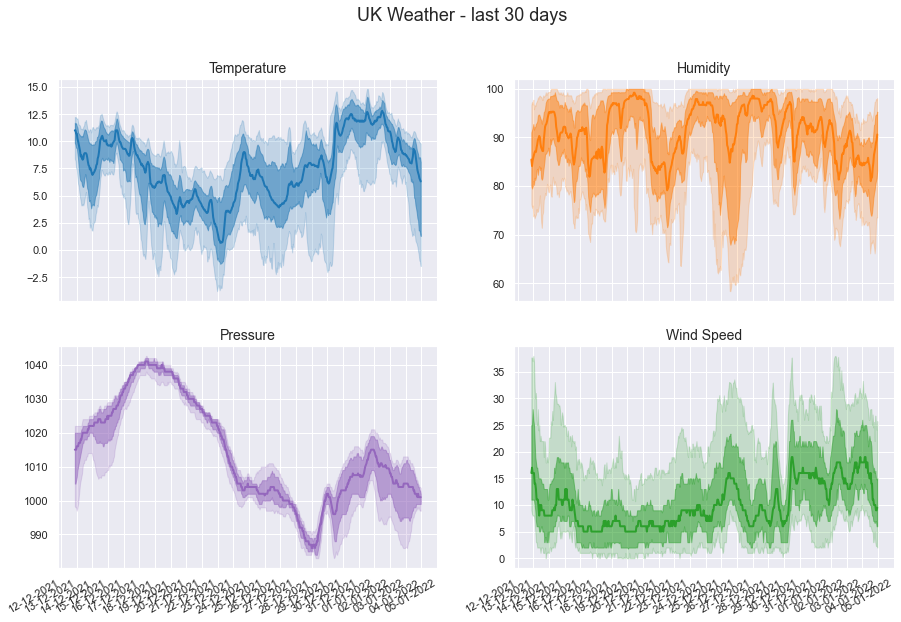

In [46]:
f, axes = plt.subplots(2, 2, figsize=(15, 10))
f.suptitle('UK Weather - last 30 days', size=18)

outer_min = 0.05
outer_max = 0.95
mean = 0.5
inner_min = 0.2
inner_max = 0.8

charts = [
    {"x": 0, "y": 0, "title": "Temperature", "field": "temperature",              "color": "tab:blue"},
    {"x": 0, "y": 1, "title": "Humidity",    "field": "screen_relative_humidity", "color": "tab:orange"},
    {"x": 1, "y": 0, "title": "Pressure",    "field": "pressure",                 "color": "tab:purple"},
    {"x": 1, "y": 1, "title": "Wind Speed",  "field": "wind_speed",               "color": "tab:green"}
]

for chart in charts:
    ax = axes[chart['x'], chart['y']]

    ax.set_title(chart['title'], size=14)

    by_ts = df.groupby(['observation_ts'])[chart['field']].quantile([outer_min, outer_max, inner_min, inner_max, mean]).unstack()

    ax.plot(by_ts.index, by_ts[mean], linewidth=2.0, color=chart["color"], label=chart['title'])
    ax.fill_between(by_ts.index, by_ts[inner_min], by_ts[inner_max], alpha=0.5, color=chart["color"], label=f"{round(inner_min * 100)}th to {round(inner_max * 100)}th percentile")
    ax.fill_between(by_ts.index, by_ts[outer_min], by_ts[outer_max], alpha=0.2, color=chart["color"], label=f"{round(outer_min * 100)}th to {round(outer_max * 100)}th percentile")

    ax.xaxis.set_major_locator(DayLocator(interval=1))
    ax.xaxis.set_major_formatter(DateFormatter('%d-%m-%Y'))
    plt.gcf().autofmt_xdate()

plt.show()